In [ ]:
"""
CS-844 Generative Deep Models
Assignment 1: Neural Autoregressive Density Estimation (NADE)
Instructor name: Dr. Zulqarnain Qayyum Khan
Name: Muhammad Soban Shaukat
Registration Number: 538822
Date of submission: February 19, 2026
"""


'\nCS-844 Generative Deep Models\nAssignment 1: Neural Autoregressive Density Estimation (NADE)\n\nName: Muhammad Soban Shaukat\nRegistration Number: 538822\nDate: February 17, 2026\n'

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.9.0+cpu
Device: cpu


In [ ]:
class NADE(nn.Module):
    """
    Neural Autoregressive Density Estimator (NADE)

    For binary MNIST images (28x28 = 784 pixels)
    Models p(x) = p(x_1) * p(x_2|x_1) * ... * p(x_784|x_1,...,x_783)
    """

    def __init__(self, input_dim=784, hidden_dim=500):
        super(NADE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Weight matrices as per NADE paper
        # W: weights from input to hidden (shared across all conditionals)
        self.W = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)

        # V: weights from hidden to output (one per dimension)
        self.V = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)

        # Biases
        self.c = nn.Parameter(torch.zeros(hidden_dim))  # hidden bias
        self.b = nn.Parameter(torch.zeros(input_dim))   # output bias

    def forward(self, x):
        """
        Compute log probability log p(x)

        Args:
            x: Binary input tensor of shape (batch_size, 784)

        Returns:
            log_prob: Log probability of the input
        """
        batch_size = x.shape[0]
        log_prob = torch.zeros(batch_size, device=x.device)

        # Initialize pre-activation: a_0 = c
        a = self.c.unsqueeze(0).repeat(batch_size, 1)

        # Autoregressive computation
        for d in range(self.input_dim):
            # Hidden state: h_d = tanh(a_d)
            h = torch.tanh(a)

            # Compute p(x_d | x_<d) using hidden state h_d
            logit = torch.matmul(h, self.V[d]) + self.b[d]
            prob_d = torch.sigmoid(logit)

            # Add to log probability
            log_prob += x[:, d] * torch.log(prob_d + 1e-8) + \
                        (1 - x[:, d]) * torch.log(1 - prob_d + 1e-8)

            # Update pre-activation: a_{d+1} = a_d + W_{:,d} * x_d
            if d < self.input_dim - 1:
                a = a + x[:, d].unsqueeze(1) * self.W[:, d]

        return log_prob

    def sample(self, n_samples=1):
        """
        Generate samples from the model using ancestral sampling

        Args:
            n_samples: Number of samples to generate

        Returns:
            samples: Generated binary images (n_samples, 784)
        """
        samples = torch.zeros(n_samples, self.input_dim)

        # Initialize pre-activation
        a = self.c.unsqueeze(0).repeat(n_samples, 1)

        # Generate each pixel sequentially
        for d in range(self.input_dim):
            # Hidden state: h_d = tanh(a_d)
            h = torch.tanh(a)

            # Compute probability p(x_d | x_<d)
            logit = torch.matmul(h, self.V[d]) + self.b[d]
            prob_d = torch.sigmoid(logit)

            # Sample from Bernoulli distribution
            samples[:, d] = torch.bernoulli(prob_d)

            # Update pre-activation for next pixel
            if d < self.input_dim - 1:
                a = a + samples[:, d].unsqueeze(1) * self.W[:, d]

        return samples

print("NADE model class defined successfully!")


NADE model class defined successfully!


In [ ]:
# Create NADE model
model = NADE(input_dim=784, hidden_dim=500)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model initialized with {total_params:,} parameters")
print(f"Input dimension: {model.input_dim}")
print(f"Hidden dimension: {model.hidden_dim}")


Model initialized with 785,284 parameters
Input dimension: 784
Hidden dimension: 500


In [ ]:
# Generate sample images
print("Generating samples from NADE model...")
n_samples = 16  # Generate 16 samples for visualization

with torch.no_grad():
    generated_samples = model.sample(n_samples=n_samples)

print(f"Generated {n_samples} samples")
print(f"Sample shape: {generated_samples.shape}")
print(f"Sample values (binary): min={generated_samples.min():.0f}, max={generated_samples.max():.0f}")


Generating samples from NADE model...
Generated 16 samples
Sample shape: torch.Size([16, 784])
Sample values (binary): min=0, max=1


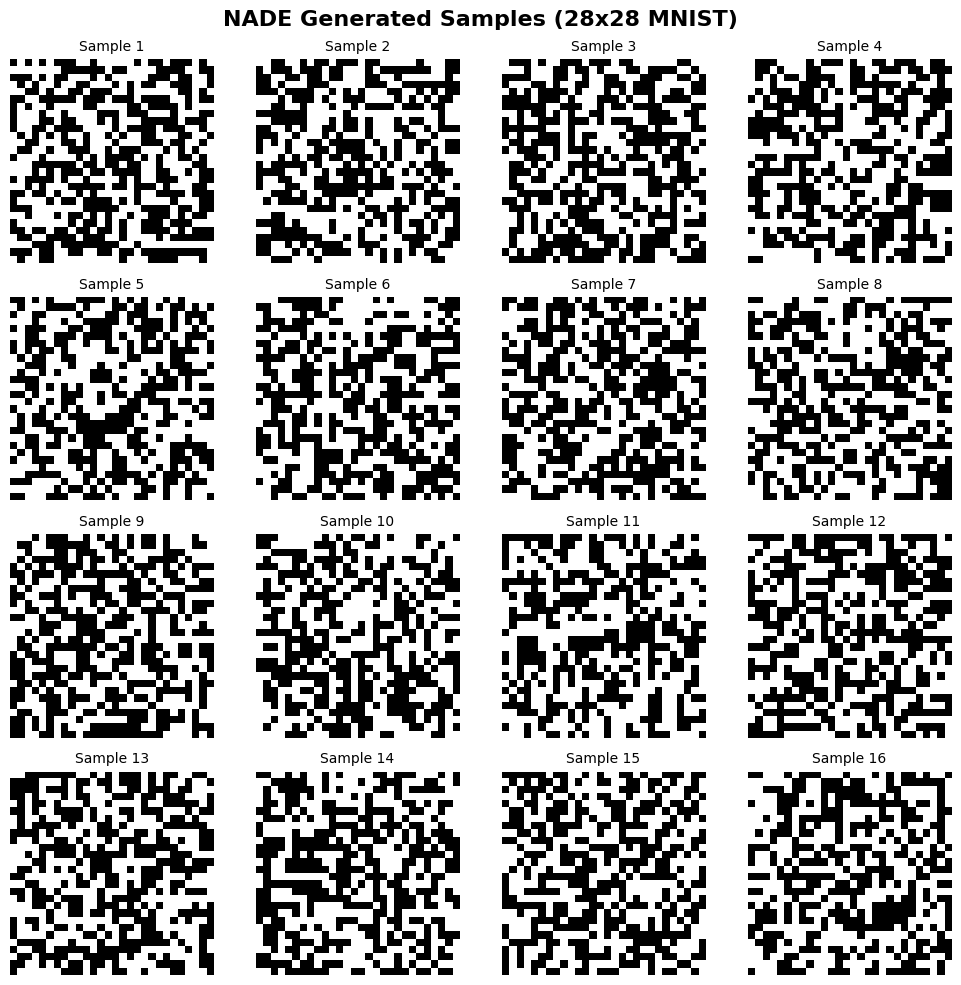


✓ Visualization complete!


In [ ]:
# Visualize the generated samples
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('NADE Generated Samples (28x28 MNIST)', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    # Reshape from 784 to 28x28
    img = generated_samples[idx].reshape(28, 28).numpy()

    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Sample {idx+1}', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


In [ ]:
print("="*60)
print("NADE MODEL SUMMARY")
print("="*60)
print(f"Architecture: Neural Autoregressive Density Estimator")
print(f"Input dimensions: 28×28 = {model.input_dim} pixels")
print(f"Hidden layer size: {model.hidden_dim} units")
print(f"Total parameters: {total_params:,}")
print(f"\nWeight matrices:")
print(f"  W (input→hidden): {model.W.shape}")
print(f"  V (hidden→output): {model.V.shape}")
print(f"  c (hidden bias): {model.c.shape}")
print(f"  b (output bias): {model.b.shape}")
print(f"\nSampling method: Ancestral sampling")
print(f"Samples generated: {n_samples}")
print("="*60)


NADE MODEL SUMMARY
Architecture: Neural Autoregressive Density Estimator
Input dimensions: 28×28 = 784 pixels
Hidden layer size: 500 units
Total parameters: 785,284

Weight matrices:
  W (input→hidden): torch.Size([500, 784])
  V (hidden→output): torch.Size([784, 500])
  c (hidden bias): torch.Size([500])
  b (output bias): torch.Size([784])

Sampling method: Ancestral sampling
Samples generated: 16
